# Simple 2D Sparse GP
We will test to ensure that our sparse GP implementation works correctly in this notebook.

## Generate Syntethic Data
We generate a simple dataset for testing with inputs in the range [0, 200]. We'll use a sinusoidal function with some noise added.

In [1]:
import numpy as onp  # Using numpy for data generation, JAX will be used for computation
import matplotlib.pyplot as plt

from kernels import *
from sparse_gp import *

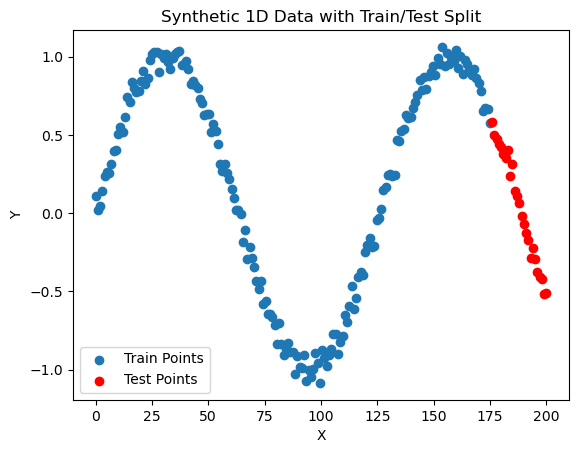

In [2]:
# Inputs
X = onp.linspace(0, 200, 200).reshape(-1, 1)
# Outputs: Sine function with noise
Y = onp.sin(X * 0.05) + 0.05 * onp.random.normal(size=X.shape)

# Training and testing split
X_train, Y_train = X[:175], Y[:175]
X_test, Y_test = X[175:], Y[175:]

# Plot data
plt.scatter(X_train, Y_train, label="Train Points")
plt.scatter(X_test, Y_test, label="Test Points", color="red")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Synthetic 1D Data with Train/Test Split")
plt.show()

## Parameter Initialization

In [3]:
# Initialize PRNG
init_prng(0)

# Initialize inducing points as a subset of X_train
Z = initialize_inducing_points(X_train, num_inducing=20)

# Define a function to initialize hyperparameters for the combined kernel
def random_init_combined_hyperparams():
    # Assuming two kernels, with unconstrained weights and initial values for each kernel's hyperparams
    initial_weights = [onp.log(0.5), onp.log(0.5)]  # log-space for unconstrained initial weights
    hyperparams_sqexp = [0.1, 1.0, 10.0]  # Initial values for noise, signal, length_scale for sq-exp kernel
    hyperparams_linear = [0.1, 1.0]  # Initial values for noise, signal for linear kernel
    
    # Concatenate all hyperparameters
    initial_params = initial_weights + hyperparams_sqexp + hyperparams_linear
    return np.array(initial_params)

# Initialize hyperparameters in the unconstrained space
unconstrained_hyperparams_init = random_init_combined_hyperparams()

## Define the Optimization Loop for ELBO

In [4]:
# Set the gradient ascent step size and number of steps
step_size = 5e-3
num_steps = 200

# Optimize ELBO using the empirical Bayes function
optimized_hyperparams, final_elbo = empirical_bayes(X_train, Y_train, Z, unconstrained_hyperparams_init, step_size, num_steps)

print("Optimized Hyperparameters:", optimized_hyperparams)
print("Final ELBO Value:", final_elbo)

Step 0, ELBO: -184.10974049217478
Step 10, ELBO: -119.93813182716158
Step 20, ELBO: 1.7734728206916088
Step 30, ELBO: 12.274002734680494
Step 40, ELBO: 12.289521834599128
Step 50, ELBO: 12.302879308588075
Step 60, ELBO: 12.315662047657298
Step 70, ELBO: 12.327981308229624
Step 80, ELBO: 12.339887113962817
Step 90, ELBO: 12.351417458166992
Step 100, ELBO: 12.36260539153821
Step 110, ELBO: 12.373480363541148
Step 120, ELBO: 12.384068678765004
Step 130, ELBO: 12.394393832125871
Step 140, ELBO: 12.404476776797878
Step 150, ELBO: 12.41433616589407
Step 160, ELBO: 12.42398854444778
Step 170, ELBO: 12.433448527624506
Step 180, ELBO: 12.442728957800313
Step 190, ELBO: 12.45184103061689
Optimized Hyperparameters: [9.95111812e-01 4.88818787e-03 1.10517092e+00 6.41676900e+00
 4.72117188e+03 9.14535311e-01 2.12431889e+00]
Final ELBO Value: 12.459905975124599


In [5]:
print("Optimized Hyperparameters:", optimized_hyperparams)
print("sum of first 2 weights:", np.sum(optimized_hyperparams[:2]))

Optimized Hyperparameters: [9.95111812e-01 4.88818787e-03 1.10517092e+00 6.41676900e+00
 4.72117188e+03 9.14535311e-01 2.12431889e+00]
sum of first 2 weights: 0.9999999999999999


## Predict and Plot the Results

K_XZ shape: (175, 20)
K_ZZ shape: (20, 20)
K_starZ shape: (25, 20)
A shape: (20, 175)
B shape: (175, 175)
alpha shape: (175, 1)
posterior_mean shape: (25, 1)
posterior_cov shape: (25, 25)
posterior_var shape: (25,)


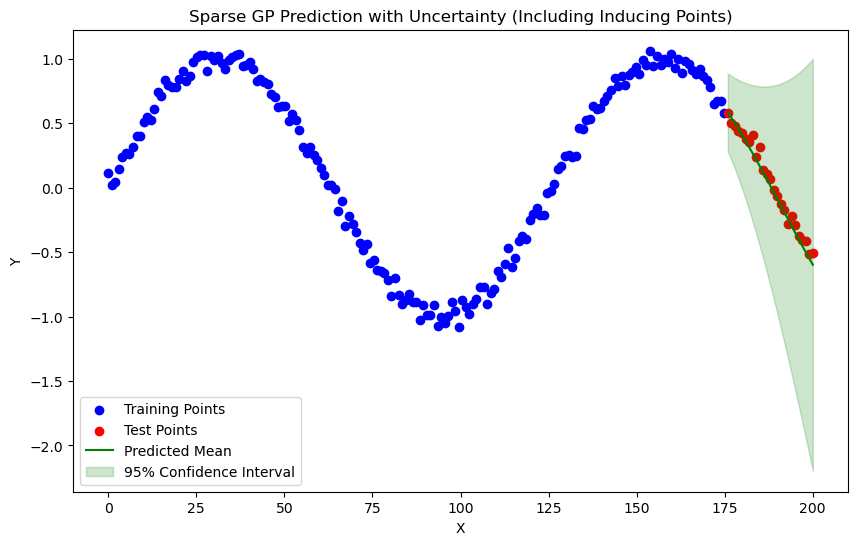

In [6]:
# Ensure input arrays are two-dimensional
X_test = X_test.reshape(-1, 1)
X_train = X_train.reshape(-1, 1)
Z = Z.reshape(-1, 1)

# Make predictions on test set using the optimized hyperparameters
posterior_mean, posterior_var = sparse_gp_posterior_predictive(X_test, X_train, Y_train, Z, optimized_hyperparams)

# Convert JAX arrays to NumPy arrays and ensure all are 1D for plotting
import numpy as onp
posterior_mean = onp.array(posterior_mean).flatten()
posterior_var = onp.array(posterior_var).flatten()
X_test = onp.array(X_test).flatten()

# Ensure all variances are positive
posterior_var = np.maximum(posterior_var, 1e-10)

# Plot the points, predictive mean, and confidence interval with inducing points
plt.figure(figsize=(10, 6))
plt.scatter(X_train, Y_train, color='blue', label="Training Points")
plt.scatter(X_test, Y_test, color='red', label="Test Points")

# Plot predictive mean line and 95% confidence interval
plt.plot(X_test, posterior_mean, 'green', label="Predicted Mean")
plt.fill_between(X_test,
                 (posterior_mean - 1.96 * np.sqrt(posterior_var)),
                 (posterior_mean + 1.96 * np.sqrt(posterior_var)),
                 color='green', alpha=0.2, label="95% Confidence Interval")

plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.title("Sparse GP Prediction with Uncertainty (Including Inducing Points)")
plt.show()

In [7]:
# Extract weights from optimized hyperparameters (assuming the first two entries are the weights)
weights = optimized_hyperparams[:2]

# Convert weights to percentages
weight_percentages = (weights / np.sum(weights)) * 100

# Print weights as percentages for each kernel
print("Kernel Weights as Percentages:")
print(f"Kernel 1 (Squared-Exponential): {weight_percentages[0]:.2f}%")
print(f"Kernel 2 (Linear): {weight_percentages[1]:.2f}%")

# Print other hyperparameters for each kernel
print("\nOther Hyperparameters:")
print(f"Kernel 1 - Noise Variance: {optimized_hyperparams[2]:.4f}")
print(f"Kernel 1 - Signal Variance: {optimized_hyperparams[3]:.4f}")
print(f"Kernel 1 - Length Scale: {optimized_hyperparams[4]:.4f}")
print(f"Kernel 2 - Noise Variance: {optimized_hyperparams[5]:.4f}")
print(f"Kernel 2 - Signal Variance: {optimized_hyperparams[6]:.4f}")

Kernel Weights as Percentages:
Kernel 1 (Squared-Exponential): 99.51%
Kernel 2 (Linear): 0.49%

Other Hyperparameters:
Kernel 1 - Noise Variance: 1.1052
Kernel 1 - Signal Variance: 6.4168
Kernel 1 - Length Scale: 4721.1719
Kernel 2 - Noise Variance: 0.9145
Kernel 2 - Signal Variance: 2.1243
